## Hereditary Geometry Discovery

- Simultaneously learn:
    - 1. Tensor that aligns Kernels (the left-action).
    - 2. Learn generator W that contains log of left-actions.
- Not implemented yet:
    - 1. Charts
    - 2. Symmetry Penalizer

In [1]:
import pickle

from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

TASK_0_NAME="sac_circle_rotation_task_0"
TASK_1_NAME="sac_circle_rotation_task_1"
TASK_2_NAME="sac_circle_rotation_task_2"

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000


def load_replay_buffer_and_kernel(task_name:str, load_what:str, kernel_dim: int, n_samples:int):
    """Loads samples and kernel evaluator of a task."""

    assert load_what in ["observations", "actions", "next_observations"], "Learn hereditary geometry for states, actions or next states."

    buffer_name= f"{task_name}_replay_buffer.pkl"
    kernel_name= f"{task_name}_kernel_bases.pkl"

    buffer= load_replay_buffer(buffer_name, N_steps=n_samples)
    ps=buffer[load_what]
    print(f"Loaded {load_what} from {buffer_name} with shape {ps.shape}")

    # Load kernel bases
    frameestimator=KernelFrameEstimator(ps=ps, kernel_dim=kernel_dim)
    with open(kernel_name, 'rb') as f:
        kernel_samples = pickle.load(f)
    frameestimator.set_frame(frame=kernel_samples)

    return ps, frameestimator

ps_task_0, frameestimator_task_0 = load_replay_buffer_and_kernel(TASK_0_NAME, "next_observations", kernel_dim=KERNEL_DIM, n_samples=N_SAMPLES)
ps_task_1, frameestimator_task_1 = load_replay_buffer_and_kernel(TASK_1_NAME, "next_observations", kernel_dim=KERNEL_DIM, n_samples=N_SAMPLES)
ps_task_2, frameestimator_task_2 = load_replay_buffer_and_kernel(TASK_2_NAME, "next_observations", kernel_dim=KERNEL_DIM, n_samples=N_SAMPLES)

2025-07-02 14:45:01.991670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
INFO:faiss:Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [118]:
%load_ext autoreload
%autoreload 2
import torch
from src.learning.symmetry_discovery.differential.hereditary_geometry_discovery import HereditaryGeometryDiscovery


SEED=42
train_goal_locations = [{'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])}]

tasks_ps= [ps_task_0, ps_task_1, ps_task_2]
tasks_frameestimators= [frameestimator_task_0, frameestimator_task_1, frameestimator_task_2]
her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,tasks_frameestimators=tasks_frameestimators, kernel_dim=KERNEL_DIM, batch_size=64, seed=SEED, bandwidth=0.5,
                                        task_specifications=train_goal_locations)
her_geo_dis.optimize(n_steps=100_000)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:40: UserWarning: Only one left base action implemented.
  warnings.warn("Only one left base action implemented.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loss: 2.8547e-01: 100%|██████████| 100000/100000 [04:07<00:00, 404.68it/s]


In [123]:
np.array(her_geo_dis._losses).shape

(100000, 2)

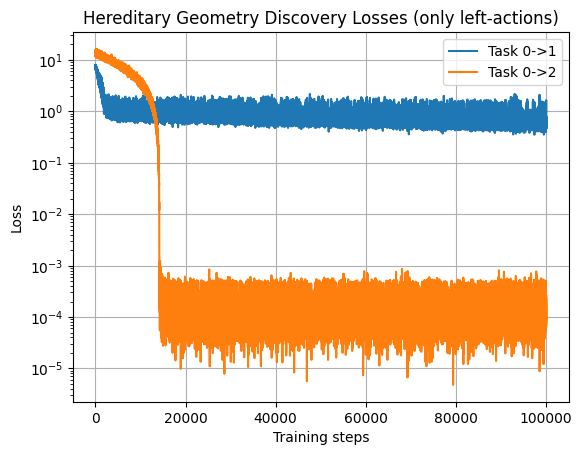

In [124]:
import matplotlib.pyplot as plt

plt.plot(np.array(her_geo_dis._losses)[:, 0], label="Task 0->1")
plt.plot(np.array(her_geo_dis._losses)[:, 1], label="Task 0->2")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Hereditary Geometry Discovery Losses (only left-actions)")
plt.show()

Compute oracle loss

In [111]:
import torch

def rotation_matrix_2d(v, u):
    v = v / torch.norm(v)
    u = u / torch.norm(u)
    c = torch.dot(u, v)
    s = u[0] * v[1] - u[1] * v[0]  # 2D scalar cross product
    R = torch.tensor([[c, -s],
                      [s,  c]])
    return R

train_goal_locations = [
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
    {'goal': torch.tensor([ 0.95243384, -0.30474544])},
    {'goal': torch.tensor([-0.11289421, -0.99360701])}
]

v1 = train_goal_locations[0]['goal']
v2 = train_goal_locations[1]['goal']
v3 = train_goal_locations[2]['goal']

R_21 = rotation_matrix_2d(v2, v1)  # Rotates v2 to v1 direction
R_31 = rotation_matrix_2d(v1, v3)  # Rotates v3 to v1 direction

In [125]:
oracle_lgs=torch.stack([R_21, R_31],dim=0)
oracle_lgs.shape

her_geo_dis.evalute_left_actions(lgs=oracle_lgs, idx_task_base=0, track_loss=False)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in idx_task_is])
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/hereditary_geometry_discovery.py:219: UserWarning: Using hard-coded kernel. Only use for debugging.
  warnings.warn("Using hard-coded kernel. Only use for debugging.")


tensor(8.2061)

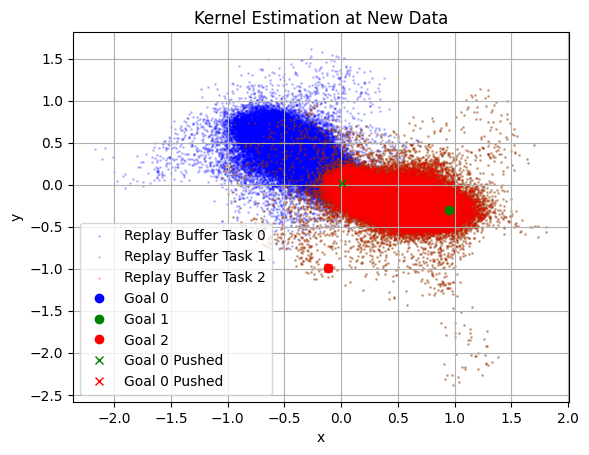

In [149]:
goal_0_pushed=torch.einsum("Nnm,m->Nn", her_geo_dis.lgs, train_goal_locations[0]["goal"]).detach().numpy()  # shape (n_tasks-1, b, n)


plt.scatter(ps_task_0[:, 0], ps_task_0[:, 1], label='Replay Buffer Task 0', s=1, alpha=0.2, c="blue")
plt.scatter(ps_task_1[:, 0], ps_task_1[:, 1], label='Replay Buffer Task 1', s=1, alpha=0.2, c="green")
plt.scatter(ps_task_2[:, 0], ps_task_2[:, 1], label='Replay Buffer Task 2', s=1, alpha=0.2, c="red")

plt.plot(train_goal_locations[0]["goal"][0], train_goal_locations[0]["goal"][1], 'bo', label='Goal 0')
plt.plot(train_goal_locations[1]["goal"][0], train_goal_locations[1]["goal"][1], 'go', label='Goal 1')
plt.plot(train_goal_locations[2]["goal"][0], train_goal_locations[2]["goal"][1], 'ro', label='Goal 2')

plt.plot(goal_0_pushed[0,0], goal_0_pushed[0,1], "gx",label='Goal 0 Pushed', linewidth=50)
plt.plot(goal_0_pushed[1,0], goal_0_pushed[1,1], "rx",label='Goal 0 Pushed')

# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Estimation at New Data')
plt.grid()
plt.show()

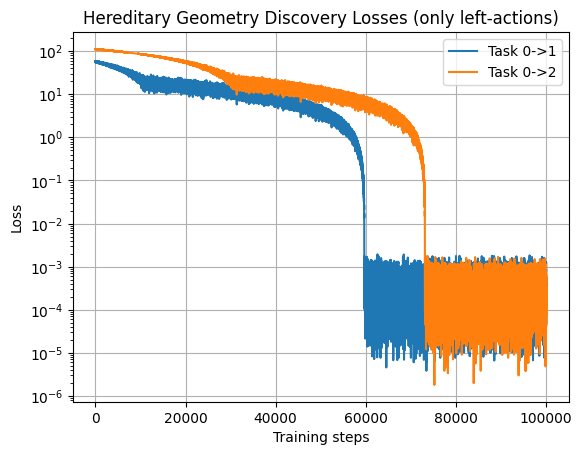

In [53]:
import matplotlib.pyplot as plt

plt.plot(task_losses[:, 0], label="Task 0->1")
plt.plot(task_losses[:, 1], label="Task 0->2")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Hereditary Geometry Discovery Losses (only left-actions)")
plt.show()